In [1]:
%cd ..

/home/user/hft-backtesting


In [2]:
import glob
import os
import datetime
import random
from tqdm import notebook

from collections import deque, namedtuple, defaultdict
from typing import Union, List, Dict, Tuple, NamedTuple, Deque, Optional

import pandas as pd
import numpy as np

In [3]:
from hft.utils import logger
logger.to_file = True
logger.fmt_string = "%(message)s"

from hft.backtesting.backtest import BacktestOnSample
from hft.backtesting.data import OrderStatus, OrderRequest
from hft.backtesting.readers import OrderbookReader
from hft.backtesting.strategy import Strategy, CancelsApplied
from hft.units.metrics.composite import Lipton
from hft.units.metrics.instant import VWAP_volume, LiquiditySpectrum, HayashiYoshido
from hft.units.metrics.time import TradeMetric
from hft.utils.data import Trade, OrderBook
from hft.backtesting.output import make_plot_orderbook_trade, Output, SimulatedOrdersOutput

## Dueling DQN 

Dueling DQN implementation with target network implementation on pytorch.  

In [4]:
import torch
from torch import nn
from torch import autograd

class DuelingDQN(nn.Module):
  def __init__(self, input_dim: int, output_dim: int):
    super().__init__()
    self.input_dim: int = input_dim
    self.output_dim: int = output_dim

    self.feature_layer = nn.Sequential(
      nn.Linear(input_dim, 256),
      nn.LayerNorm(256),
      nn.ReLU(),
      nn.Linear(256, 256),
      nn.LayerNorm(256),
      nn.ReLU()
    )

    self.value_stream = nn.Sequential(
      nn.Linear(256, 128),
      nn.LayerNorm(128),
      nn.ReLU(),
      nn.Linear(128, 1)
    )

    self.advantage_stream = nn.Sequential(
      nn.Linear(256, 256),
      nn.LayerNorm(256),
      nn.ReLU(),
      nn.Linear(256, self.output_dim)
    )

  def forward(self, x):
    x = self.feature_layer(x)
    value = self.value_stream(x)
    adv = self.advantage_stream(x)
    qvals = value + (adv - adv.mean())
    return value, adv, qvals

## Decision condition

Class defines moments when model will make actions.  
Model's reaction on __each__ snapshot update would be incredibly expensive, thus it reacts _volume-based_.  

In [5]:
class DecisionCondition:
  def __init__(self, mu: float, std: float = 1.0):
    assert mu > 0
    assert std > 0

    self.mu = mu
    self.std = std
    self.lower = self.mu * 0.5
    self.upper = self.mu * 1.5

    self.volume_condition: float = self._generate_volume()
    self.reset()

  def _generate_volume(self):
    v = random.gauss(self.mu, self.std)
    clipped = self.lower if v < self.lower else self.upper if v > self.upper else v
    return clipped


  def __call__(self, is_trade: bool, event: Union[Trade, OrderBook]):
    if is_trade and event.symbol == 'XBTUSD':
      self.volume += event.volume
      if self.volume > self.volume_condition:
        self.volume %= self.volume_condition
        self.volume_condition = self._generate_volume()
        return True
    return False

  def reset(self):
    self.volume = 0.0

## Agent

Class stores inner operation for RL:

- Stores _replay buffer_  
- Generates actions via model or random  
- Evaluates rewards and updates models  

In [6]:
class Agent:
  def __init__(self, model: DuelingDQN, target: DuelingDQN,
               condition: DecisionCondition,
               gamma=0.98, lr=1e-3,
               update_each: int = 100,
               buffer_size: int = 20000, batch_size=1024):
    self._replay_buffer: Deque[State] = deque(maxlen=buffer_size)
    self._batch_size: int = batch_size
    self.condition: DecisionCondition = condition
    self._model: DuelingDQN = model
    self._target: DuelingDQN = target
    self.end_episode_states: List = []
    self.episode_files: List[Tuple[str, str]] = []

    self.EPS_START = 0.9
    self.EPS_END = 0.05
    self.EPS_DECAY = 250

    self.gamma = gamma
    self.loss = torch.nn.SmoothL1Loss()
    self.losses = []
    self.optimizer = torch.optim.Adam(self._model.parameters(), lr=lr, amsgrad=True)

    self._update_each = update_each
    self.episode_counter = 0

    self.no_action_event = deque(maxlen=20)
    self.reset_state()
    self._is_training: bool = True

  def train(self):
    self._is_training = True
    self._model.train()
    self._target.eval()

  def eval(self):
    self._is_training = False
    self._model.eval()
    self._target.eval()

  def store_no_action(self, ts, price):
    self.no_action_event[0].append((ts, price))

  def episode_results(self) -> pd.DataFrame:
    fnames, states = agent.episode_files, agent.end_episode_states
    states = [t[0].tolist() + [t[1]] for t in states]
    episodes = [list(t[0]) + t[1] for t in zip(fnames, states)]
    res = pd.DataFrame(episodes, columns=['ob_file', 'tr_file', 'usd', 'xbt', 'eth', 'xbt_price'])
    res['nav'] = res.usd + res.xbt_price * res.xbt
    return res

  def reset_state(self):
    self.obs = None
    self.action = None
    self.ps = None
    self.episode_counter += 1
    self.condition.reset()
    self.no_action_event.appendleft([])

    # reload weights
    state = self._model.state_dict()
    if (self.episode_counter + 1) % self._update_each == 0:
      self._target.load_state_dict(state)
      torch.save(state, f'models/model-v2_2-{self.episode_counter+1}.pth')
    torch.save(state, f'model-latest-v2_2.pth')

  def get_new_reward(self, ps, ps_new, price, sigma, scale_rav=1.0/10, a=1.0):
    g1 = self.get_risk_adjusted_state_value(ps, price, sigma, scale=scale_rav)
    g2 = self.get_risk_adjusted_state_value(ps_new, price, sigma, scale=scale_rav)
    return a * (g2 - g1)

  def get_risk_adjusted_state_value(self, ps: torch.FloatTensor, price: torch.FloatTensor, sigma: torch.FloatTensor,
                                    tau=1.0, lambd=0.2, scale=1.0 / 10):
    nav = (ps[:, 0] + ps[:, 1]) * price  # updated to dollar NAV
    risk = torch.abs(ps[:, 1] * price) * tau * sigma  # updated here: sqrt of tau ; N(1, 1) * tau, sigma \in 1e-5

    return (nav - lambd * risk) * scale

  def store_episode(self, new_obs, done, action, prices):
    if self._is_training:
      nans = [np.isnan(t).any() for t in [new_obs, done, action, prices]]
      if not any(nans):
        if self.is_initialized():
          self._replay_buffer.append((self.obs, self.action, new_obs, done, prices))
        self.obs = new_obs
        self.action = action
        self.prices = prices

  def is_initialized(self):
    return self.obs is not None  # happens after reset, first obs is missing

  def get_action(self, obs):
    if self._is_training:
      eps = self.EPS_END + (self.EPS_START - self.EPS_END) * np.exp(-1. * self.episode_counter / self.EPS_DECAY)
      if np.random.uniform(0.0, 1.0) < eps :
        return random.randint(0, self._model.output_dim - 1)
    with torch.no_grad():
      _, _, qvals = self._target(torch.tensor(obs, dtype=torch.float, device=device).unsqueeze(0))
      action = torch.argmax(qvals).cpu().detach().item()
      return action

  def update(self):
    if len(self._replay_buffer) > self._batch_size and self._is_training:
      items = random.sample(self._replay_buffer, self._batch_size)
      obs, action, next_obs, done, price = zip(*items)
      obs, next_obs, price = map(lambda x: torch.tensor(x, dtype=torch.float).to(device), [obs, next_obs, price])
      done = torch.tensor(done, dtype=torch.bool).to(device)
      action = torch.tensor(action, dtype=torch.long).unsqueeze(1).to(device)

      ps, rs            = obs[:, -3:-1], obs[:, -1]
      next_ps, next_rs  = next_obs[:, -3:-1], next_obs[:, -1]

      qvalues = self._model(obs)[2]
      next_qvalues = self._target(next_obs[~done])[2]
      next_qvalues = next_qvalues.max(1)[0]

      rewards = torch.zeros(size=done.shape, dtype=torch.float, device=device)
      rewards[~done] = self.get_new_reward(ps[~done], next_ps[~done], price[~done], rs[~done])
      rewards[done]  = self.get_risk_adjusted_state_value(next_ps[done], price[done], rs[done])

      rewards = rewards.clamp(-1.5, 1.5)  # reward clipping

      qvalues = qvalues.gather(1, action).squeeze(1)

      expected_q = torch.zeros(size=done.shape, dtype=torch.float, device=device)
      expected_q[~done] = self.gamma * next_qvalues
      expected_q += rewards

      loss = self.loss(qvalues, expected_q)  # or hubert loss
      self.losses.append(loss.detach().cpu().sum().item())
      if torch.isinf(loss).any() or torch.isnan(loss).any():
        print('nan is here')
      self.optimizer.zero_grad()
      loss.backward()
      for param in self._model.parameters():
        param.grad.data.clamp_(-1., 1.)  # gradient clipping
      self.optimizer.step()

## RL Strategy

Class wrapper for RL operations: 

- Provides observations, portfolio states
- Transforms action space into orders
- Communicates with backtest

In [7]:
class VWAP_modification(VWAP_volume):
  def __init__(self, T=10, **kwargs):
    super().__init__(**kwargs)
    self.storage = defaultdict(lambda: deque(maxlen=T))
    self.low   = defaultdict(lambda: None)
    self.high =  defaultdict(lambda: None)
    self.close = defaultdict(lambda: None)
    self.open =  defaultdict(lambda: None)
    self.last =  defaultdict(lambda: None)

  '''
  VWAP modification: returns vwap_offset and vwap_spread instead of bid,ask,midprice

  Also computes RS volatility
  '''
  def _evaluate(self, snapshot: OrderBook) -> np.array:
    vwap: np.array = super()._evaluate(snapshot)
    vwap_spread = (vwap[1,:] - vwap[0,:]) - 0.5  # vwap_ask - vwap_bid - default_spread
    midprice = (snapshot.bid_prices[0] + snapshot.ask_prices[0]) / 2
    vwap_offset = np.abs(vwap[[0,1], :] - midprice)

    self.process(vwap[2, :], snapshot.symbol) # compute RS based on vwap_midprices

    return np.vstack([vwap_offset, vwap_spread]) # 3 rows

  def process(self, result: np.array, symbol: str):
    if self.open[symbol] is None:
      self.open[symbol] = result
      self.low[symbol] = result
      self.high[symbol] = result
    else:
      self.low[symbol] = np.minimum(self.low[symbol], result)
      self.high[symbol] = np.maximum(self.high[symbol], result)

    self.last[symbol] = result

  def reset(self, symbol: str) -> np.array:
    self.close[symbol] = self.last[symbol]

    sigma_sq = np.log(self.high[symbol] / self.close[symbol]) * np.log(self.high[symbol] / self.open[symbol])\
               + np.log(self.low[symbol] / self.close[symbol]) * np.log(self.low[symbol] / self.open[symbol])
    self.storage[symbol].append(sigma_sq)

    self.low[symbol] = self.last[symbol]
    self.high[symbol] = self.last[symbol]
    self.open[symbol] = self.last[symbol]

    return np.sqrt(np.sum(self.storage[symbol], axis=0) / len(self.storage[symbol]) + 1e-8) + 1e-4

In [18]:
class RLStrategy(Strategy):
  def __init__(self, agent: Agent, rs: 'VWAP_modification', episode_length: int, cancels_enabled=False, **kwags):
    super().__init__(**kwags)
    self.agent: Agent = agent
    self.rs: VWAP_modification = rs
    # self._simulation_end: datetime.datetime = simulation_end
    self.action_space: Dict[int, Tuple[int, int]] = {
      0: (-1, 0),
      1: (0, -1),
      2: (-1, -1),
      3: (0, 0),
      4: (0, 1),
      5: (1, 0),
      6: (1, 1),
      7: (-1, 1),
      8: (1, -1),
    }
    self.cancels_enabled = cancels_enabled
    self.no_action_event = []
    self._episode_length = episode_length
    self.prices = None
    
  def _balance_listener(self, memory: Dict[str, Union[Trade, OrderBook]],
                        ts: datetime.datetime,
                        orders: List[OrderRequest],
                        statuses: List[OrderStatus]):
    if self.balance_listener is not None and (len(orders) > 0 or len(statuses) > 0):
      midpoint_xbt = (memory[('orderbook', 'XBTUSD')].bid_prices[0] + memory[('orderbook', 'XBTUSD')].ask_prices[0]) / 2

      state = (self.balance['USD'], self.balance['XBTUSD'], midpoint_xbt, ts, *self.position['XBTUSD'])
      self.balance_listener(state)

  def return_unfinished(self, statuses: List[OrderStatus], memory: Dict[str, Union[Trade, OrderBook]]):
    super().return_unfinished(statuses, memory)
    rs = self.rs.reset('XBTUSD')[0]
    obs, ps, prices = self.get_observation(memory, rs)
    self.agent.store_episode(obs, True, 0, prices)
    self.agent.end_episode_states.append((ps, prices, self.pennies))  # end state and prices
    self.agent.reset_state()

  def get_price_change(self, price) -> np.array:
    storage1: List[Trade] = self.metrics_map['trade-metric-120'].storage[('XBTUSD', 0)]
    storage2: List[Trade] = self.metrics_map['trade-metric-60'].storage[('XBTUSD', 0)]

    prices1 = np.array([t.price for t in storage1])
    prices2 = np.array([t.price for t in storage2])

    pc1 = (price - prices1.mean()) / 0.5  # xbtusd price step = 0.5 USD
    pc2 = (price - prices2.mean()) / 0.5  # xbtusd price step = 0.5 USD
    pc = np.array([pc1, pc2], dtype=np.float)

    return np.sign(pc) * np.log(np.abs(pc) + 1)

  def get_observation(self, memory, rs):
    items = list(map(lambda name: self.metrics_map[name].to_numpy('XBTUSD'), names + time_names))

    prices = self.get_prices(memory)
    pc = self.get_price_change(prices) # price change
    items = np.concatenate([t.flatten() for t in items + [pc]]).clip(-5.0, 5.0)

    ps = self.get_state()

    state = np.array([ps[0] / prices, ps[1], rs], dtype=np.float)
    items = np.concatenate([items, state], axis=None)
    return items, ps, prices

  def get_prices(self, memory) -> float:  # todo: refactor and use vwap
    xbt: OrderBook = memory[('orderbook', 'XBTUSD')]
    xbt_midprice = (xbt.ask_prices[0] + xbt.bid_prices[0]) / 2

    # eth: OrderBook = memory[('orderbook', 'ETHUSD')]
    # eth_midprice = (eth.ask_prices[0] + eth.bid_prices[0]) / 2

    return xbt_midprice

  def get_state(self) -> np.array:
    return np.array(list(self.balance.values()))

  def get_timeleft(self, ts: datetime.datetime) -> float:
    t = ((self._simulation_end - ts).total_seconds() % self._episode_length) / self._episode_length
    return (t - 0.5) * 2
    # 10 minute episodes

  def action_to_order(self, action: int, memory, ts, quantity: int) -> List[OrderRequest]:
    offset_bid, offset_ask = self.action_space[action]

    offset_bid *= 0.5  # price step is .5 dollars
    offset_ask *= 0.5

    ob: OrderBook = memory[('orderbook', 'XBTUSD')]
    orders = []

    if offset_bid >= 0:
      orders.append(OrderRequest.create_bid(ob.bid_prices[0] - offset_bid, quantity, 'XBTUSD', ts))
    if offset_ask >= 0:
      orders.append(OrderRequest.create_ask(ob.ask_prices[0] + offset_ask, quantity, 'XBTUSD', ts))

    return orders

  def cancel_orders(self, statuses: List[OrderStatus], ts: datetime.datetime) -> List[OrderRequest]:
    statuses_ids = list(map(lambda x: x.id, statuses))
    active_ids = self.active_orders.keys()
    active_non_present = filter(lambda x: x not in statuses_ids, active_ids)
    return list(map(lambda x: OrderRequest.cancelOrder(self.active_orders[x], ts), active_non_present))

  def define_orders(self, row: Union[Trade, OrderBook],
                    statuses: List[OrderStatus],
                    memory: Dict[str, Union[Trade, OrderBook]],
                    is_trade: bool) -> List[OrderRequest]:
    if self.agent.condition(is_trade, row):
      orders = []
      cancels = []
      if self.cancels_enabled:
        cancels = self.cancel_orders(statuses, row.timestamp)
        orders += cancels

      rs = self.rs.reset('XBTUSD')[0]
      with CancelsApplied(self, cancels):
        obs, ps, prices = self.get_observation(memory, rs)
        action = self.agent.get_action(obs)
        if action == 2:
          self.agent.store_no_action(row.timestamp, prices)
        self.agent.store_episode(obs, False, action, prices)

      self.agent.update()

      orders += self.action_to_order(action, memory, row.timestamp, 1000)

    else:
      orders = []
    return orders

## Training loop

In [19]:
# matrices: [2, 4, 2], [2,3,2], [2, 2], [2]
names = ['vwap', 'liquidity-spectrum', 'hayashi-yoshido', 'lipton']
# [2, 2], [2, 2]
time_names = ['trade-metric-60', 'trade-metric-120']

### Simulation wrapper

In [21]:
def compare_strategies(s1: RLStrategy, s2, orderbook_file: str, trade_file: str,
                       delay=1) -> Tuple:

  r1 = TimeLimitedReader(orderbook_file, limit_time='100 min', trades_file=trade_file, nrows=500000)
  r2 = TimeLimitedReader(orderbook_file, limit_time='100 min', trades_file=trade_file, nrows=500000)

  o1 = SimulatedOrdersOutput()
  o2 = SimulatedOrdersOutput()

  s1.balance_listener = o1.balances.append
  s2.balance_listener = o2.balances.append

  b1 = Backtest(r1, s1, o1, delay=delay, warmup=True, stale_depth=8)
  b2 = Backtest(r2, s2, o2, delay=delay, warmup=False, stale_depth=2)

  b1.run()
  b2.run()

  return o1, o2

In [22]:
def prepare_rl_strategy(agent: Agent, cancels_enabled=True) -> RLStrategy:
  vwap = VWAP_modification(T=20, volumes=[5e5, 1e6], name='vwap', z_normalize=1000)
  liq = LiquiditySpectrum(z_normalize=3000)

  defaults = [
    (('XBTUSD', 0), [0.0]),
    (('XBTUSD', 1), [0.0]),
    (('ETHUSD', 0), [0.0]),
    (('ETHUSD', 1), [0.0]),
  ]

  trade_metric = TradeMetric(defaults, [
    # ('quantity', lambda x: len(x)),
    ('total', lambda trades: sum(map(lambda x: x.volume, trades)))
  ], seconds=60, z_normalize=2500)
  trade_metric2 = TradeMetric(defaults, [
    # ('quantity', lambda x: len(x)),
    ('total', lambda trades: sum(map(lambda x: x.volume, trades)))
  ], seconds=120, z_normalize=2500)

  lipton_levels = 6
  hy = HayashiYoshido(140, True)
  lipton = Lipton(hy.name, lipton_levels)
  return RLStrategy(agent, vwap, episode_length=600,
                        instant_metrics=[vwap, liq],
                        delta_metrics=[hy],
                        time_metrics_trade=[trade_metric, trade_metric2], composite_metrics=[lipton],
                        initial_balance=0.0, cancels_enabled=cancels_enabled)

In [23]:
def init_simulation(agent: Agent, orderbook_file: str, trade_file: str,
                    output_required: Union[bool, Output] = False, delay=5,
                    cancels_enabled=True) -> Optional[Output]:

  if isinstance(output_required, bool) and output_required:
    output = SimulatedOrdersOutput()
  elif isinstance(output_required, Output):
    output = output_required
  else:
    output = None

  reader = OrderbookReader(orderbook_file, trade_file, nrows=None, is_precomputed=True)

  strategy = prepare_rl_strategy(agent, cancels_enabled)
  backtest = BacktestOnSample(reader, strategy, output=output, delay=delay, warmup=True, stale_depth=8)
  backtest.run()

  return backtest.output

In [24]:
import matplotlib.pyplot as plt
def plot_from_df(idx, info=True, savefig=False, output=None):
    import matplotlib.patches as mpatches
    
    if output is None:
        output = outputs[idx]
    orders_side1, orders_side2 = list(output.orders.values())
    ob_file = res.ob_file.iloc[idx]
    fig, axs = make_plot_orderbook_trade(ob_file, 'XBTUSD', 
                          orders_side1 + orders_side2, 
                          None,
                          orderbook_precomputed=True, savefig=savefig)
    
    if info:
        assert idx < 0 
        ob_file, pnl, xbt, usd, price = res.loc[len(res)+idx, ['ob_file', 'nav', 'xbt', 'usd', 'xbt_price']] 
        patches = [
            mpatches.Patch(color='red', label=f'PNL: {pnl:.3f} USD'),
            mpatches.Patch(color='green', label=f'Price: {price:.2f} USD'),
            mpatches.Patch(color='blue', label=f'XBT: {xbt:.3f}'),
            mpatches.Patch(color='yellow', label=f'USD: {usd:.3f}')
        ]
        
        main_legend = plt.legend(loc=1)
        plt.legend(handles=patches, loc=2)
        plt.gca().add_artist(main_legend)
        
        plt.title(ob_file.split('/')[-1])
    plt.show()

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.autograd.set_detect_anomaly(True)
# device = torch.device('cpu')

device

device(type='cuda')

In [26]:
condition = DecisionCondition(150000.0, 3000.0)
model: DuelingDQN = DuelingDQN(input_dim=24, output_dim=4)
target: DuelingDQN = DuelingDQN(input_dim=24, output_dim=4)

model.load_state_dict(torch.load('model-2-2.pth'))
model.train()
target.eval()
target.load_state_dict(model.state_dict())


model.to(device)
target.to(device)
agent = Agent(model, target, condition, batch_size=256) # for some reason, batch_size > 64 makes NANs in loss
agent.train()

## Training

In [16]:
dst_dir = 'notebooks/time-sampled-10min'
ob_files = glob.glob(f'{dst_dir}/orderbook_*')
tr_files = glob.glob(f'{dst_dir}/trade_*')
ob_files, tr_files = map(sorted, [ob_files, tr_files])

pairs = list(zip(ob_files, tr_files))
outputs: List[SimulatedOrdersOutput] = []

In [17]:
total = 1810

In [18]:
agent.train()
for idx in notebook.tqdm(range(total)):
    output_required = True if total - 20 < idx else False
    ob_file, tr_file = random.choice(pairs)
    output = init_simulation(agent, ob_file, tr_file, output_required=output_required, delay=1)
    agent.episode_files.append((ob_file, tr_file))
    outputs.append(output)

/home/user/hft-backtesting/hft/backtesting/strategy.py:179: RuntimeWarning: overflow encountered in double_scalars
  self.position[order.symbol] = ((avg_price * (1.0 - ratio) + order.price * ratio), total_volume)


In [42]:
# res.to_csv('RL-v2-2.csv')
# torch.save(target.state_dict(), 'model-2-2.pth')

In [41]:
model

DuelingDQN(
  (feature_layer): Sequential(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
  )
  (value_stream): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
  (advantage_stream): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=4, bias=True)
  )
)

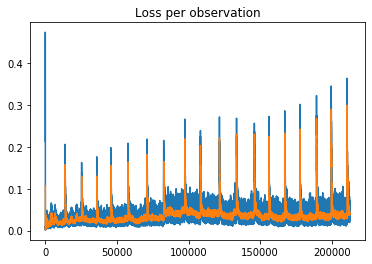

In [19]:
losses = pd.Series(agent.losses)
# losses = losses.clip(0, 0.02)
t = len(losses)
_mean = losses.rolling(20).mean()

plt.title('Loss per observation')
plt.plot(np.arange(0, t), np.array(losses))
plt.plot(range(t), _mean)
plt.show()

## Results overview

In [20]:
res = agent.episode_results()
res

,ob_file,tr_file,usd,xbt,eth,xbt_price,nav
0,notebooks/time-sampled-10min/orderbook_1190.cs...,notebooks/time-sampled-10min/trade_1190.csv.gz,2976.83275,-0.553470,0.0,5215.50,90.209458
1,notebooks/time-sampled-10min/orderbook_2053.cs...,notebooks/time-sampled-10min/trade_2053.csv.gz,-1200.52225,0.177197,0.0,6726.75,-8.560549
2,notebooks/time-sampled-10min/orderbook_2002.cs...,notebooks/time-sampled-10min/trade_2002.csv.gz,8991.45750,-1.368314,0.0,6601.75,-41.811194
3,notebooks/time-sampled-10min/orderbook_1298.cs...,notebooks/time-sampled-10min/trade_1298.csv.gz,-17190.27225,3.058474,0.0,5603.75,-51.351243
4,notebooks/time-sampled-10min/orderbook_6.csv.gz,notebooks/time-sampled-10min/trade_6.csv.gz,14187.76775,-1.791938,0.0,7924.75,-12.891929
...,...,...,...,...,...,...,...
1805,notebooks/time-sampled-10min/orderbook_482.csv.gz,notebooks/time-sampled-10min/trade_482.csv.gz,6542.32325,-1.185672,0.0,5580.75,-74.616168
1806,notebooks/time-sampled-10min/orderbook_142.csv.gz,notebooks/time-sampled-10min/trade_142.csv.gz,11780.06000,-1.528157,0.0,7709.75,-1.648917
1807,notebooks/time-sampled-10min/orderbook_2006.cs...,notebooks/time-sampled-10min/trade_2006.csv.gz,4303.24050,-0.653155,0.0,6587.75,0.419761
1808,notebooks/time-sampled-10min/orderbook_157.csv.gz,notebooks/time-sampled-10min/trade_157.csv.gz,-7540.96550,0.963903,0.0,7817.25,-5.894458


In [50]:
# res.to_csv('RL-v2-2.csv')

In [23]:
positives = res[-100:][res.nav > 0]
negatives = res[-100:][res.nav < 0]

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [24]:
pos_sum, neg_sum = positives.nav.sum(), negatives.nav.sum()
pos_max, neg_min = positives.nav.max(), negatives.nav.min()
print(f'Positives sum: {pos_sum:.4f}; '   +
      f'\nNegatives sum: {neg_sum:.4f}; ' +
      f'\nPositives max: {pos_max:.4f}; ' +
      f'\nNegatives min: {neg_min:.4f}')

Positives sum: 1069.8740; 
Negatives sum: -6580.0588; 
Positives max: 212.6328; 
Negatives min: -2065.2928


In [25]:
summary = pd.concat([positives.nav, -negatives.nav], axis=1)
summary.columns = ['positive', 'negative']
summary.describe()

,positive,negative
count,31.000000,69.000000
mean,34.512064,95.363172
std,51.808180,271.871223
min,0.419761,0.118681
25%,4.439674,6.507634
50%,11.071803,17.612562
75%,46.681931,55.874889
max,212.632838,2065.292758


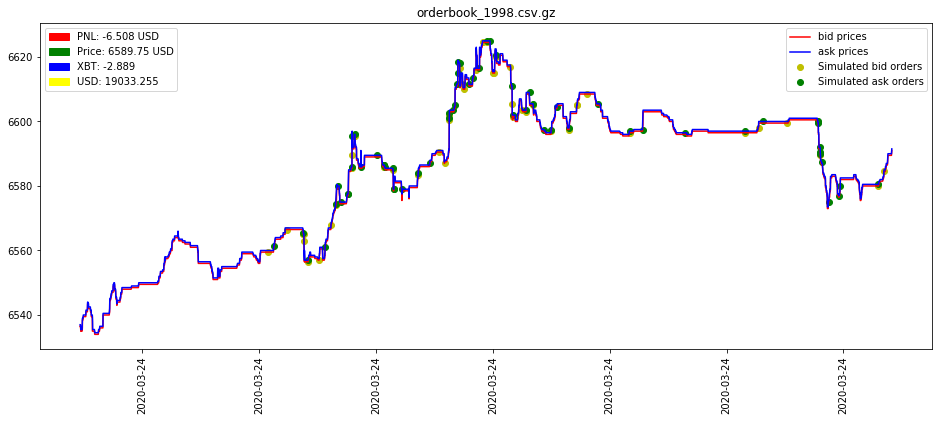

In [26]:
plot_from_df(-1)

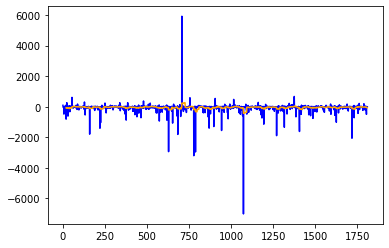

In [27]:
_mean = res.nav.rolling(20).mean()
plt.plot(range(0, len(res.nav)), res.nav, c='blue')
plt.plot(range(0, len(_mean)), _mean, c='orange')

# Results comparison

Gatling vs RL Agent

In [30]:
dst_dir = 'notebooks/time-sampled-30min'
ob_files = glob.glob(f'{dst_dir}/orderbook_*')
tr_files = glob.glob(f'{dst_dir}/trade_*')
ob_files, tr_files = map(sorted, [ob_files, tr_files])

eval_pairs = list(zip(ob_files, tr_files))
# outputs: List[SimulatedOrdersOutput] = []

In [31]:
agent.eval()
agent.reset_state()

for i in notebook.tqdm(range(5)):
    ob_file, tr_file = random.choice(eval_pairs)
    output = init_simulation(agent, ob_file, tr_file, output_required=True, delay=1)
    agent.episode_files.append((ob_file, tr_file))
    outputs.append(output)

In [32]:
res = agent.episode_results()
res

,ob_file,tr_file,usd,xbt,eth,xbt_price,nav
0,notebooks/time-sampled-10min/orderbook_1190.cs...,notebooks/time-sampled-10min/trade_1190.csv.gz,2976.83275,-0.553470,0.0,5215.50,90.209458
1,notebooks/time-sampled-10min/orderbook_2053.cs...,notebooks/time-sampled-10min/trade_2053.csv.gz,-1200.52225,0.177197,0.0,6726.75,-8.560549
2,notebooks/time-sampled-10min/orderbook_2002.cs...,notebooks/time-sampled-10min/trade_2002.csv.gz,8991.45750,-1.368314,0.0,6601.75,-41.811194
3,notebooks/time-sampled-10min/orderbook_1298.cs...,notebooks/time-sampled-10min/trade_1298.csv.gz,-17190.27225,3.058474,0.0,5603.75,-51.351243
4,notebooks/time-sampled-10min/orderbook_6.csv.gz,notebooks/time-sampled-10min/trade_6.csv.gz,14187.76775,-1.791938,0.0,7924.75,-12.891929
...,...,...,...,...,...,...,...
1810,notebooks/time-sampled-30min/orderbook_620.csv.gz,notebooks/time-sampled-30min/trade_620.csv.gz,485.13725,-0.075383,0.0,6293.75,10.693895
1811,notebooks/time-sampled-30min/orderbook_521.csv.gz,notebooks/time-sampled-30min/trade_521.csv.gz,11738.46700,-1.764620,0.0,6635.25,29.769624
1812,notebooks/time-sampled-30min/orderbook_144.csv.gz,notebooks/time-sampled-30min/trade_144.csv.gz,197795.46400,-36.430900,0.0,5604.25,-6372.405168
1813,notebooks/time-sampled-30min/orderbook_30.csv.gz,notebooks/time-sampled-30min/trade_30.csv.gz,-51410.31050,6.556262,0.0,7810.25,-204.265132


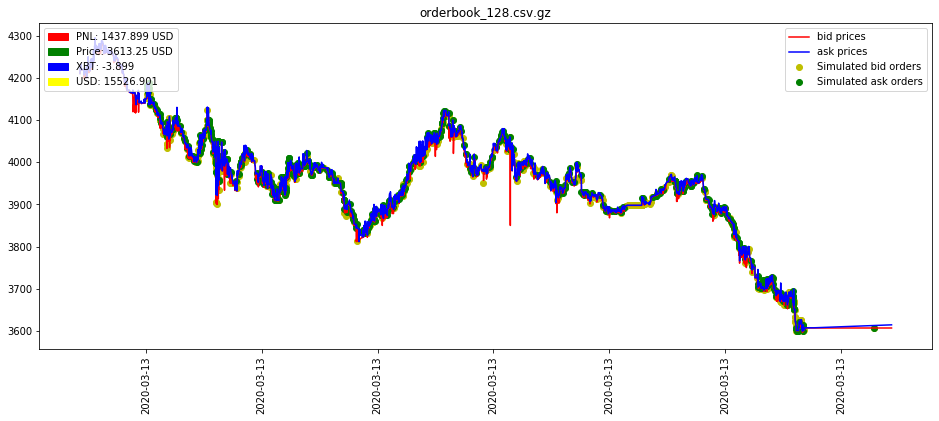

In [37]:
plot_from_df(-1)

## Compare with Gatling

In [27]:
# def compare_strategies(s1: RLStrategy, s2, orderbook_file: str, trade_file: str,
#                        delay=1) -> Tuple:

#   r1 = TimeLimitedReader(orderbook_file, limit_time='100 min', trades_file=trade_file, nrows=500000)
#   r2 = TimeLimitedReader(orderbook_file, limit_time='100 min', trades_file=trade_file, nrows=500000)

#   o1 = SimulatedOrdersOutput()
#   o2 = SimulatedOrdersOutput()

#   s1.balance_listener = o1.balances.append
#   s2.balance_listener = o2.balances.append

#   b1 = Backtest(r1, s1, o1, delay=delay, warmup=True, stale_depth=8)
#   b2 = Backtest(r2, s2, o2, delay=delay, warmup=False, stale_depth=2)

#   b1.run()
#   b2.run()

#   return o1, o2

In [36]:
from hft.strategies.gatling import GatlingMM
from hft.backtesting.readers import OrderbookReader, TimeLimitedReader
from hft.backtesting.backtest import Backtest

In [37]:
rl = prepare_rl_strategy(agent)
gatling = GatlingMM(1000, initial_balance=0.0)
agent.eval()
ob_file = 'notebooks/may-data/orderbook.CSV.gz'
tr_file = 'notebooks/may-data/trades.CSV.gz'

In [38]:
o1, o2 = compare_strategies(rl, gatling, ob_file, tr_file)

/home/user/hft-backtesting/hft/backtesting/strategy.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = converted_volume / total_volume
/home/user/hft-backtesting/hft/backtesting/strategy.py:164: RuntimeWarning: invalid value encountered in double_scalars
  self.position[order.symbol] = ((avg_price * (1.0 - ratio) + order.price * ratio), total_volume)


In [39]:
def balance_to_df(states):
    states = pd.DataFrame(states, index=None, columns=None).loc[1:]
    states.columns = ['usd', 'xbt', 'xbt_price', 'ts', 'avprice', 'pos']
    states['nav'] = states.usd + states.xbt * states.xbt_price
    states['upnl'] = (1. / states.avprice - 1. / states.xbt_price) * states.pos
    return states

In [40]:
df1 = balance_to_df(o1.balances)
df2 = balance_to_df(o2.balances)

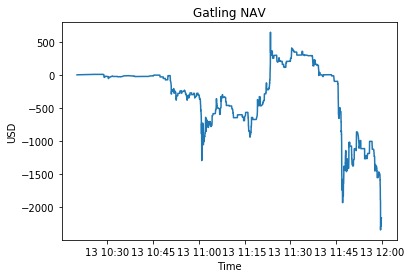

In [41]:
plt.plot(df2.ts, df2.nav)
plt.title('Gatling NAV')
plt.xlabel('Time')
plt.ylabel('USD')
plt.show()

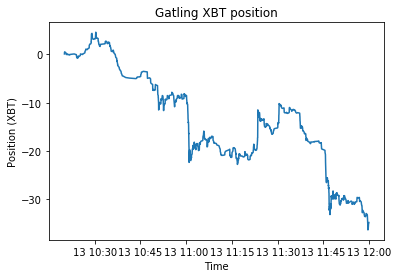

In [44]:
plt.plot(df2.ts, df2.xbt)
plt.title('Gatling XBT position')
plt.xlabel('Time')
plt.ylabel('Position (XBT)')
plt.show()

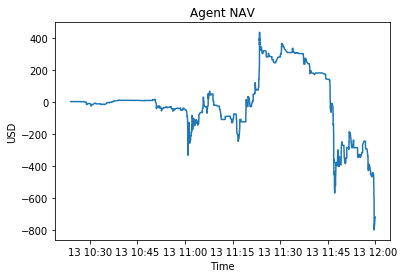

In [42]:
plt.plot(df1.ts, df1.nav)
plt.title('Agent NAV')
plt.xlabel('Time')
plt.ylabel('USD')
plt.show()

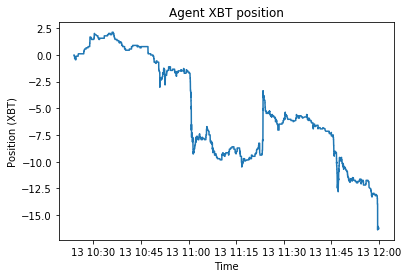

In [43]:
plt.plot(df1.ts, df1.xbt)
plt.title('Agent XBT position')
plt.xlabel('Time')
plt.ylabel('Position (XBT)')
plt.show()